# kaggle 데이터를 사용하여 만든 다중 분류 모델

데이터 로드 및 전처리까지 동일하게 진행. 통일성을 위함
https://github.com/gchaewon/OASIS_team3/blob/gchaewon/training/multi_model_training_1027.ipynb


# GPU

In [1]:
import tensorflow as tf

# 모든 GPU 장치 가져오기
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # GPU에 메모리 점진적 증가 허용 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # GPU 0에 메모리 제한 설정 (3GB)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072)]  # 3GB로 제한
        )
        print("GPU 메모리 제한 설정 완료")
    except RuntimeError as e:
        print(f"메모리 설정 에러: {e}")


GPU 메모리 제한 설정 완료


# CPU

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # GPU 사용 비활성화


## 0. Import Library

In [ ]:
# !pip install tqdm
# !pip install imblearn

In [2]:
import os 
import cv2
import pickle
import random
import pandas as pd
import numpy as np
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input  
from tensorflow.keras.models import Model

from keras.models import Sequential, load_model
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd
import tensorflow as tf

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load Data

In [2]:
# 경로 설정
data_dir = "C:/Users/USER/Desktop/Braineewha_DeepLearning_11/Kaggle"
pickle_path = os.path.join(data_dir, "dataset.pkl")  # pickle 파일 경로

# 이미지 리스트 
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

# 카테고리 리스트 및 경로 초기화
path_list = ["Mild Dementia", "Moderate Dementia", 
             "Non Demented", "Very mild Dementia"]

In [3]:
# 카테고리 별 이미지 경로 저장을 위한 딕셔너리 초기화
image_paths = {
    "Mild Dementia": [],
    "Moderate Dementia": [],
    "Non Demented": [],
    "Very mild Dementia": []
}

# 각 카테고리 별 경로 추가
for category in path_list:
    category_dir = os.path.join(data_dir, category)
    for dirname, _, filenames in os.walk(category_dir):
        for filename in filenames:
            image_paths[category].append(os.path.join(dirname, filename))

# 확인
for category in path_list:
    print(f'{category}: {len(image_paths[category])} images')

Mild Dementia: 5002 images
Moderate Dementia: 488 images
Non Demented: 67222 images
Very mild Dementia: 13725 images


In [4]:
# 각 카테고리별 파일 경로 리스트
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

images, labels = [], []

In [5]:
# 각 카테고리 폴더 내 파일 경로를 리스트에 추가
for category in tqdm(path_list):
    category_dir = os.path.join(data_dir, category)
    for root, _, filenames in os.walk(category_dir):
        for filename in filenames:
            image_path = os.path.join(root, filename)
            images.append(image_path)
            labels.append(category)
            if category == "Non Demented":
                non_demented.append(image_path)
            elif category == "Very mild Dementia":
                very_mild_demented.append(image_path)
            elif category == "Mild Dementia":
                mild_demented.append(image_path)
            elif category == "Moderate Dementia":
                moderate_demented.append(image_path)

100%|██████████| 4/4 [00:00<00:00, 12.48it/s]


In [6]:
# 이미지 경로와 레이블을 포함하는 DataFrame 생성
df = pd.DataFrame({'image': images, 'label': labels})
df.head() 

image          label
0  C:/Users/USER/Desktop/Braineewha_DeepLearning_...  Mild Dementia
1  C:/Users/USER/Desktop/Braineewha_DeepLearning_...  Mild Dementia
2  C:/Users/USER/Desktop/Braineewha_DeepLearning_...  Mild Dementia
3  C:/Users/USER/Desktop/Braineewha_DeepLearning_...  Mild Dementia
4  C:/Users/USER/Desktop/Braineewha_DeepLearning_...  Mild Dementia

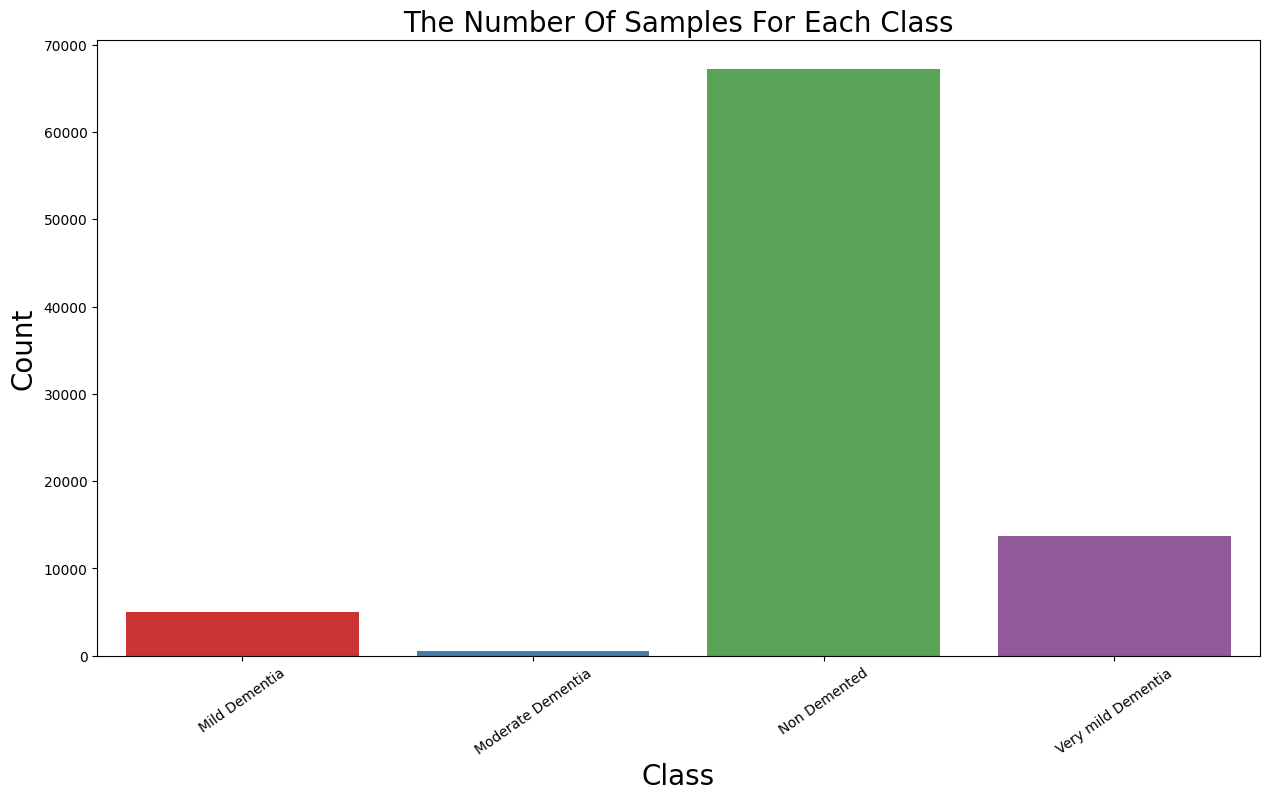

In [7]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(False)
plt.xticks(rotation=35)
plt.show()

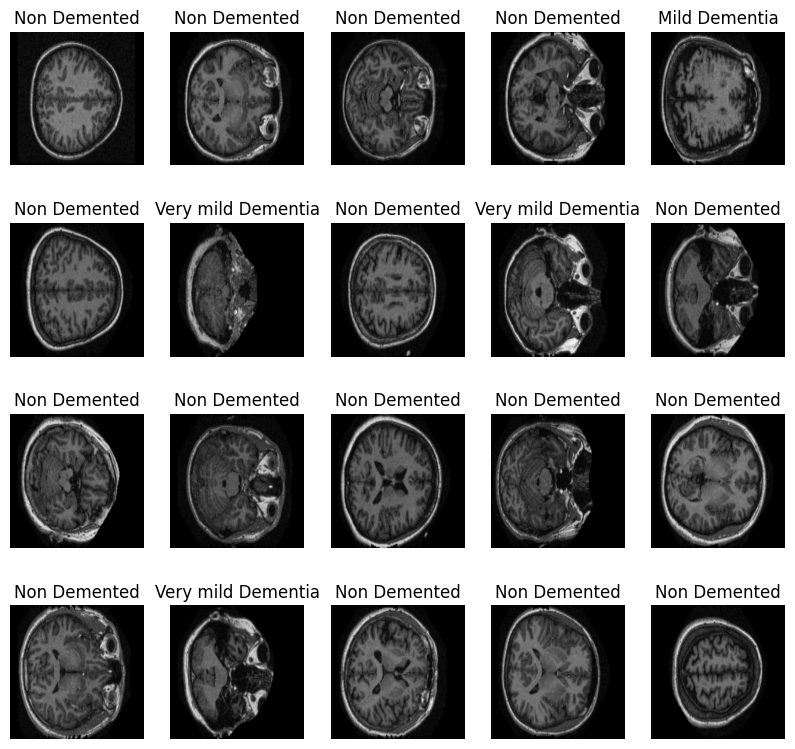

In [8]:
plt.figure(figsize=(10,12))
for n,i in enumerate(np.random.randint(0,len(df),20)):
    plt.subplot(5,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=12)

## 2. Preprocessing

In [9]:
# data = []
# result = []
''''''
# Non Demented 데이터 개수 조정
random.seed(42)
non_demented_sample = random.sample(non_demented, len(very_mild_demented) + len(mild_demented) + len(moderate_demented))

# 데이터 및 레이블 리스트 초기화
data = []
binary_labels = []

### 1) Label Encoding

In [ ]:
# encoder= OneHotEncoder()
# encoder.fit([[0],[1],[2],[3]])

OneHotEncoder()

In [10]:
# # 각 리스트에서 이미지를 읽어와 데이터와 결과에 추가하는 함수
# def load_images(category_list, label):
#     for image_path in category_list:
#         img = Image.open(image_path).convert('RGB')
#         img = img.resize((128, 128))
#         img = np.array(img)
#         data.append(img)
#         result.append(encoder.transform([[label]]).toarray())
''''''
# 각 카테고리 별 레이블 설정 및 이미지 로드 함수
def load_images(category_list, label):
    for image_path in category_list:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((128, 128))
        img = np.array(img)
        data.append(img)
        binary_labels.append(label)

In [11]:
# # 각 카테고리별로 이미지 로드
# load_images(non_demented, 0)
# load_images(very_mild_demented, 1)
# load_images(mild_demented, 2)
# load_images(moderate_demented, 3)
''''''

# 이진 분류를 위한 이미지 로드
load_images(non_demented_sample, 0)  # Non Demented
load_images(very_mild_demented, 1)
load_images(mild_demented, 1)
load_images(moderate_demented, 1)


In [ ]:
# # 결과 데이터 변환 확인
# data = np.array(data)
# result = np.array(result).reshape(len(result), -1)
# print(f"Data shape: {data.shape}, Result shape: {result.shape}")

Data shape: (86437, 128, 128, 3), Result shape: (86437, 4)


### 2) Reshape data

In [13]:
# X=np.array(data)
# y=np.array(result)
# y=y.reshape(X.shape[0],4)
# y=np.argmax(y, axis=1)

''''''
# numpy array 변환
X = np.array(data)
y = np.array(binary_labels)

### 3) Split data
stratify = y 추가

In [16]:
# X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2,random_state=42, stratify=y, shuffle = True)
# X_train.shape
# X_test.shape

''''''
# train-test split (stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y,shuffle = True)
print(X_train.shape)
print(X_test.shape)

(30744, 128, 128, 3)
(7686, 128, 128, 3)


pickle

In [17]:
# # 데이터 저장

# import pickle

# with open(pickle_path, 'wb') as f:
#     pickle.dump((X_train, X_test, y_train, y_test), f)
# print("데이터 pickle 파일로 저장 완료")
''''''
# 데이터 pickle로 저장
with open(pickle_path, 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)
print("Pickle 파일 저장 완료")

Pickle 파일 저장 완료


In [3]:
import pickle
import os

# 경로 설정
data_dir = "C:/Users/USER/Desktop/Braineewha_DeepLearning_11/Kaggle"
pickle_path = os.path.join(data_dir, "dataset.pkl")  # pickle 파일 경로

# Pickle 파일 불러오기
with open(pickle_path, 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

# 불러온 데이터 확인
print("Pickle 파일에서 데이터 불러오기 완료")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Pickle 파일에서 데이터 불러오기 완료
X_train shape: (30744, 128, 128, 3)
X_test shape: (7686, 128, 128, 3)
y_train shape: (30744,)
y_test shape: (7686,)


# * 데이터 분포

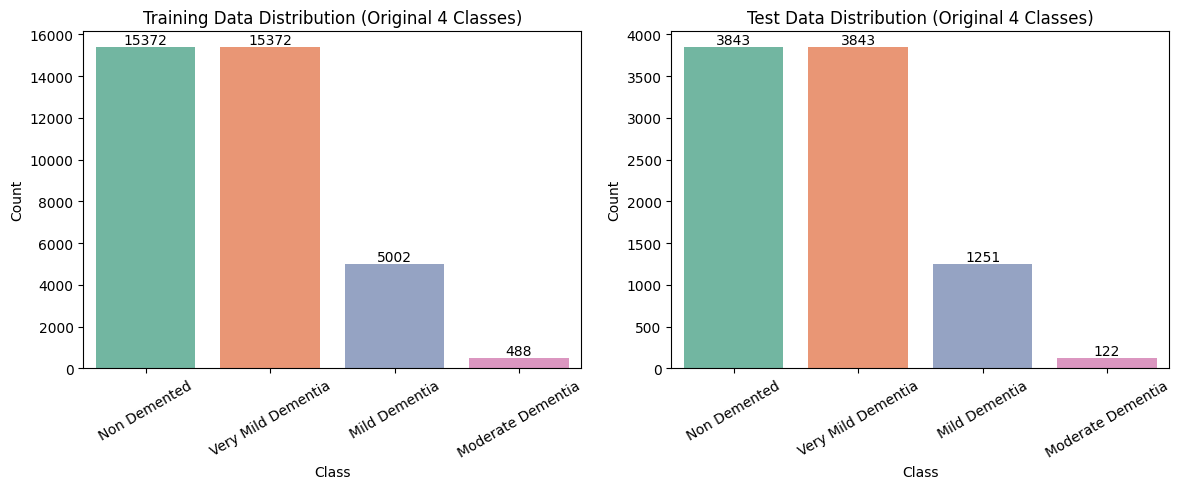

<Figure size 800x600 with 0 Axes>

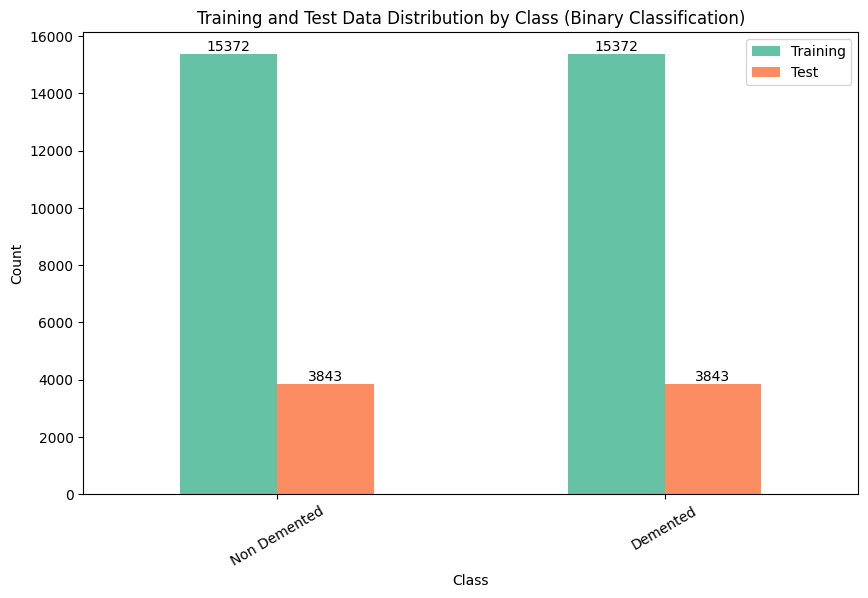

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 각 클래스별 Training과 Test 데이터 개수 설정
train_counts = {
    "Non Demented": 15372,
    "Very Mild Dementia": 15372,
    "Mild Dementia": 5002,
    "Moderate Dementia": 488
}

test_counts = {
    "Non Demented": 3843,
    "Very Mild Dementia": 3843,
    "Mild Dementia": 1251,
    "Moderate Dementia": 122
}

# DataFrame 생성
train_df = pd.DataFrame(list(train_counts.items()), columns=["Class", "Count"])
test_df = pd.DataFrame(list(test_counts.items()), columns=["Class", "Count"])

# 색상 지정
palette_colors = {"Non Demented": "#66c2a5", "Very Mild Dementia": "#fc8d62", "Mild Dementia": "#8da0cb", "Moderate Dementia": "#e78ac3"}

# 4개 클래스의 Training, Test 데이터 분포 시각화
plt.figure(figsize=(12, 5))

# 훈련 데이터 그래프
plt.subplot(1, 2, 1)
ax1 = sns.barplot(x="Class", y="Count", data=train_df, palette=palette_colors)
plt.title("Training Data Distribution (Original 4 Classes)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=30)
# 막대 위에 개수 표시
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                 ha='center', va='bottom')

# 테스트 데이터 그래프
plt.subplot(1, 2, 2)
ax2 = sns.barplot(x="Class", y="Count", data=test_df, palette=palette_colors)
plt.title("Test Data Distribution (Original 4 Classes)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=30)
# 막대 위에 개수 표시
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()



# 2


# 이진 분류 데이터 개수 계산
train_counts = {
    "Non Demented": sum(y_train == 0),
    "Demented": sum(y_train == 1)
}

test_counts = {
    "Non Demented": sum(y_test == 0),
    "Demented": sum(y_test == 1)
}

# DataFrame 생성
combined_counts = {
    "Class": ["Non Demented", "Demented"],
    "Training": [train_counts["Non Demented"], train_counts["Demented"]],
    "Test": [test_counts["Non Demented"], test_counts["Demented"]]
}

combined_df = pd.DataFrame(combined_counts)

# 2. Training과 Test 비율을 하나의 그래프로 보여주는 이진 분류 그래프
plt.figure(figsize=(8, 6))
ax = combined_df.set_index("Class").plot(kind="bar", stacked=False, figsize=(10, 6), rot=30, color=["#66c2a5", "#fc8d62"])
plt.title("Training and Test Data Distribution by Class (Binary Classification)")
plt.xlabel("Class")
plt.ylabel("Count")

# 막대 위에 개수 표시
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.show()


# *Odds ratio
1보다 클 경우 해당 클래스의 예측이 의미 있는 수준임 
모델 만들면 추가할 것

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# 저장된 모델 파일 경로
model_path = "C:/Users/USER/Desktop/Braineewha_DeepLearning_11/model/best_binary_model.keras"

# 모델 불러오기
model = load_model(model_path)

# 테스트 데이터에 대한 예측 수행
y_pred = (model.predict(X_test) > 0.5).astype(int)  # 0.5 기준으로 이진 분류

# 혼동 행렬 생성
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

# 작은 값 추가 (pseudocount)하여 Odds Ratio 계산
small_value = 1e-10  # 분모가 0이 되는 것을 방지하기 위해 아주 작은 값 추가
odds_ratio = (tp * tn) / ((fp + small_value) * (fn + small_value))

# 결과 출력
print(f"Odds Ratio: {odds_ratio:.2f}")


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
241/241 [==============================] - 7s 28ms/step
True Negatives: 3825, False Positives: 18, False Negatives: 0, True Positives: 3843
Odds Ratio: 8166374999954631.00


# * Risk Ratio

In [22]:
# 사건 발생 확률 계산
risk_exposed = tp / (tp + fn)  # 실제 양성 중 예측된 양성의 비율
risk_non_exposed = fp / (fp + tn)  # 실제 음성 중 예측된 음성의 비율

# Risk Ratio 계산
if risk_non_exposed > 0:
    risk_ratio = risk_exposed / risk_non_exposed
    print(f"Risk Ratio: {risk_ratio:.2f}")
else:
    print("Risk Ratio를 계산할 수 없습니다.")


Risk Ratio: 213.50


# * 차원축소기술 / 1110 다시 돌림!

1-1. PCA 2d

In [ ]:
!pip install umap-learn
!pip install ipywidgets

X_test shape: (7686, 128, 128, 3), y_test shape: (7686,)


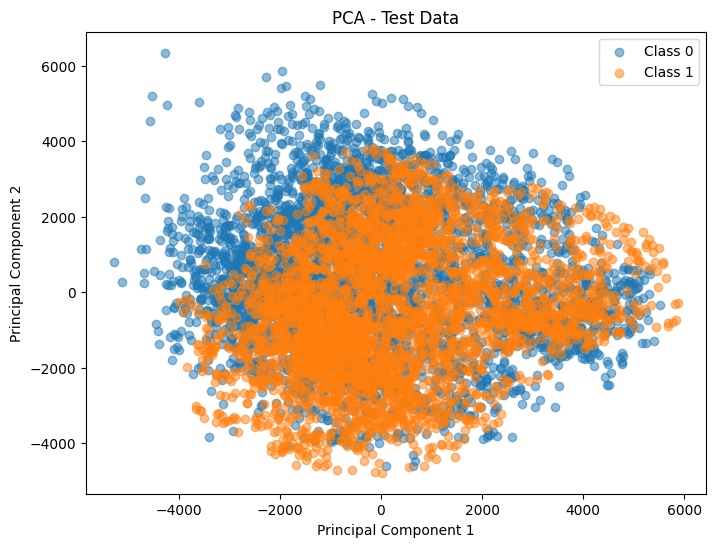

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
try:
    from importlib.metadata import version, PackageNotFoundError
except ImportError:
    from importlib_metadata import version, PackageNotFoundError
from tqdm import tqdm

# 테스트 데이터의 형태 확인
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# 1. PCA를 사용한 차원 축소
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test.reshape(X_test.shape[0], -1))

# PCA 결과 시각화
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(y_test)):
    plt.scatter(
        X_test_pca[y_test == label, 0], 
        X_test_pca[y_test == label, 1], 
        label=f"Class {label}", alpha=0.5
    )
plt.title("PCA - Test Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

1-2. PCA 3d

X_test shape: (7686, 128, 128, 3), y_test shape: (7686,)


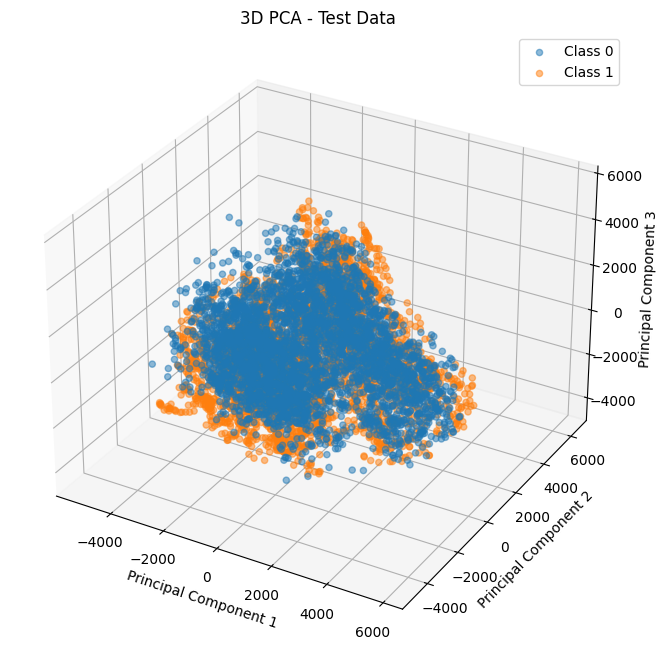

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 테스트 데이터의 형태 확인
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# PCA를 사용한 차원 축소 (3개의 주성분)
pca = PCA(n_components=3)
X_test_pca = pca.fit_transform(X_test.reshape(X_test.shape[0], -1))

# 3D PCA 결과 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, label in enumerate(np.unique(y_test)):
    ax.scatter(
        X_test_pca[y_test == label, 0], 
        X_test_pca[y_test == label, 1], 
        X_test_pca[y_test == label, 2], 
        label=f"Class {label}", alpha=0.5
    )

ax.set_title("3D PCA - Test Data")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.legend()
plt.show()


1-3. PCA 3d rotational plotly

In [13]:
!pip install plotly


   ---------------------------------------- 15.6/15.6 MB 5.8 MB/s eta 0:00:00


In [ ]:
!pip install nbformat

In [19]:
!pip install nbformat --upgrade

In [35]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA

# 테스트 데이터의 형태 확인
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# PCA를 사용한 차원 축소 (3개의 주성분)
pca = PCA(n_components=3)
X_test_pca = pca.fit_transform(X_test.reshape(X_test.shape[0], -1))

# DataFrame 생성
df = pd.DataFrame({
    'PC1': X_test_pca[:, 0],
    'PC2': X_test_pca[:, 1],
    'PC3': X_test_pca[:, 2],
    'Label': y_test
})

# Plotly로 3D 그래프 생성
fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='Label', opacity=0.7)
fig.update_layout(title="3D PCA - Test Data")
fig.show()

X_test shape: (7686, 128, 128, 3), y_test shape: (7686,)


2. UMAP

In [42]:
!pip install importlib_metadata



In [ ]:
# 2. UMAP을 사용한 차원 축소
import umap
umap_reducer = umap.UMAP(n_components=2)
X_test_umap = umap_reducer.fit_transform(X_test.reshape(X_test.shape[0], -1))

# UMAP 결과 시각화
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(y_test)):
    plt.scatter(
        X_test_umap[y_test == label, 0], 
        X_test_umap[y_test == label, 1], 
        label=f"Class {label}", alpha=0.5
    )
plt.title("UMAP - Test Data")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend()
plt.show()

3. t-SNE

c:\Users\USER\.conda\envs\syrr\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\USER\.conda\envs\syrr\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



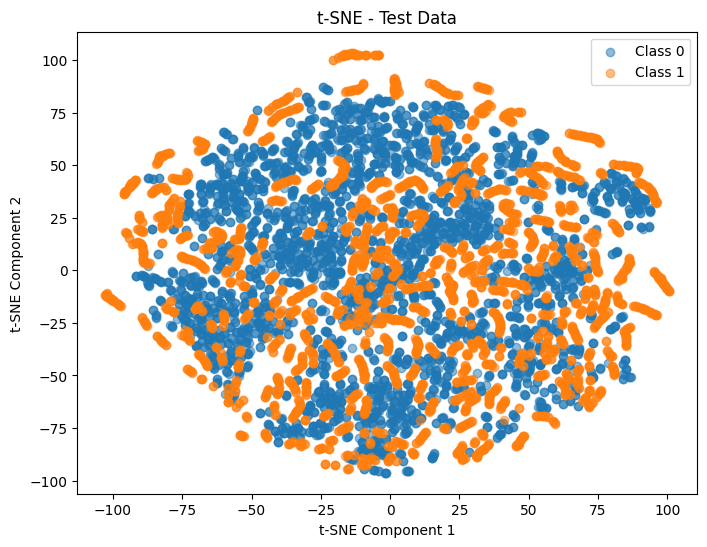

In [44]:
# 3. t-SNE를 사용한 차원 축소
tsne = TSNE(n_components=2, random_state=42)
X_test_tsne = tsne.fit_transform(X_test.reshape(X_test.shape[0], -1))

# t-SNE 결과 시각화
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(y_test)):
    plt.scatter(
        X_test_tsne[y_test == label, 0], 
        X_test_tsne[y_test == label, 1], 
        label=f"Class {label}", alpha=0.5
    )
plt.title("t-SNE - Test Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

## 3. Modeling - 이진분류, grad-cam 최적의 모델

3-0. 기본형

In [4]:
# CNN 모델 생성
def create_compile_model(learning_rate=0.001):
    model=Sequential()
    model.add(Conv2D(filters=32,kernel_size=2,padding='Same',input_shape = (128,128,3)))

    model.add(Conv2D(filters=32,kernel_size=2,padding='Same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64,kernel_size=2,padding='Same',activation='relu'))
    model.add(Conv2D(filters=64,kernel_size=2,padding='Same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=128,kernel_size=2,padding='Same',activation='relu'))
    model.add(Conv2D(filters=128,kernel_size=2,padding='Same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))
    # model.add(Dense(4,activation='softmax'))
    model.add(Dense(1, activation='sigmoid'))  # 이진 분류를 위한 출력 유닛 1개, 활성화 함수 sigmoid

    print(model.summary())

    model.compile(optimizer = 'adam',
                #   loss = 'sparse_categorical_crossentropy',
                loss='binary_crossentropy',  # 이진 분류용 손실 함수
                  metrics = ['accuracy'])
    
    return model

In [5]:
early_stopping=EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='../model/best_binary_model.keras',  
    monitor='val_loss',       
    save_best_only=True,       
    mode='min',               
    verbose=1               
)

## 4. Training

In [6]:
model = create_compile_model(learning_rate=0.001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4128      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        8

In [7]:
history= model.fit(X_train,
                   y_train,
                   validation_split=0.2,
                   epochs=30,
                   callbacks=[early_stopping, checkpoint],
                    batch_size=32,
                    verbose=1)

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
769/769 [==============================] - ETA: 0s - loss: 0.7024 - accuracy: 0.7744WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002482F3929D8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

모델 저장

In [8]:
# 최종 모델 저장
model.save('../model/best_binary_model.keras')
model.save('../model/multi_model.h5')

시각화

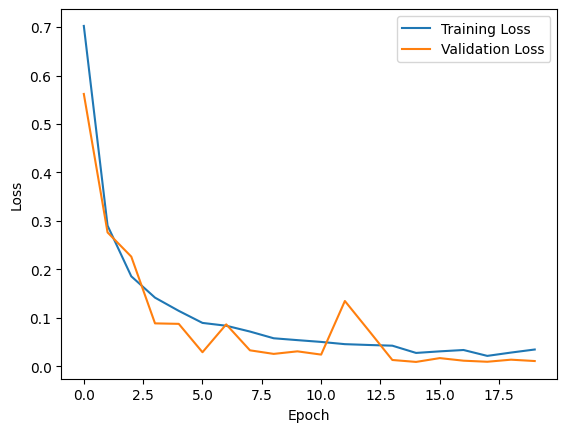

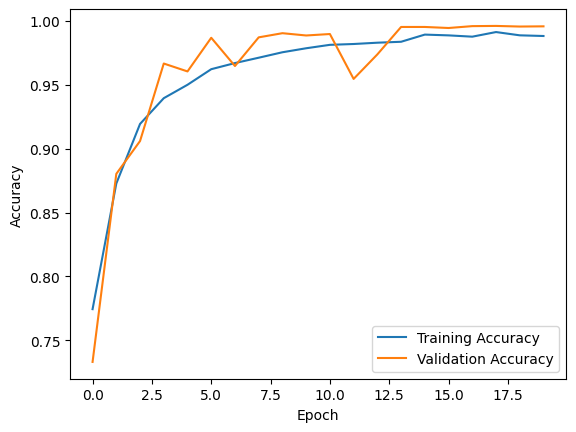

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
241/241 [==============================] - 7s 29ms/step
Accuracy: 0.9976580796252927
Precision: 0.9953379953379954
Sensitivity (Recall): 1.0
Specificity: 0.9953161592505855


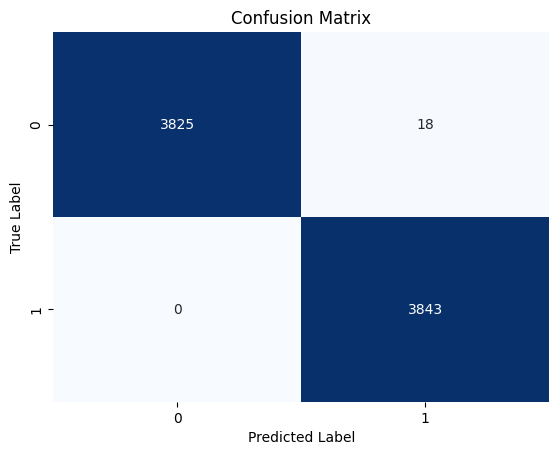

In [9]:
# Specificity 정의
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 평가 및 혼동 행렬 계산
y_pred = (model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

# 평가 지표 출력
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Sensitivity (Recall): {sensitivity}')
print(f'Specificity: {specificity}')

# 혼동 행렬 시각화
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

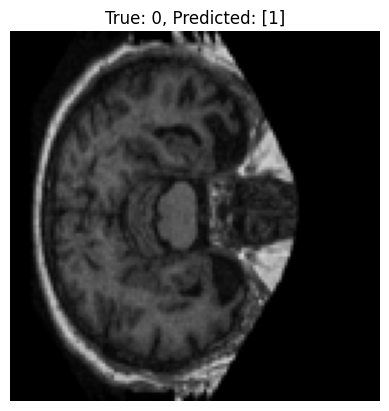

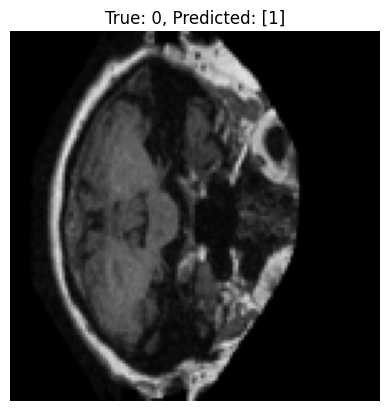

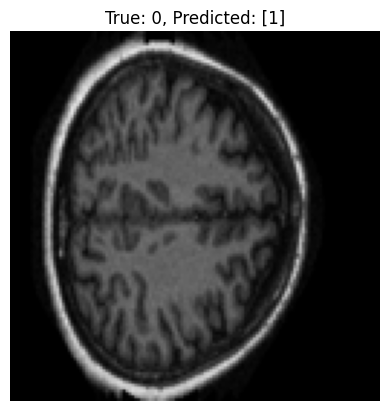

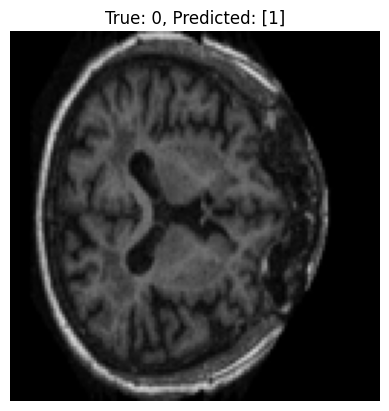

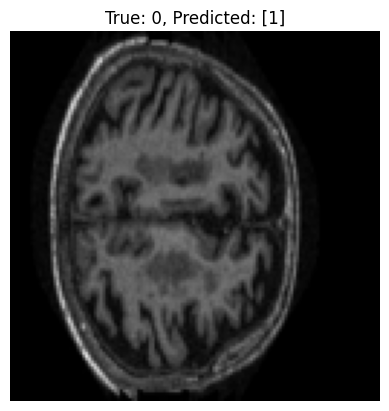

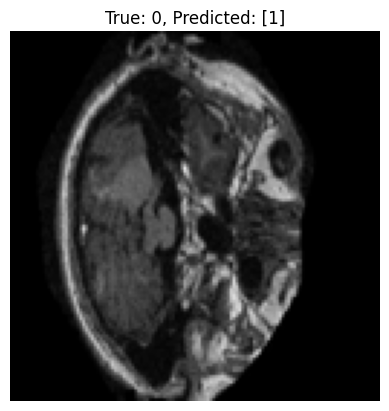

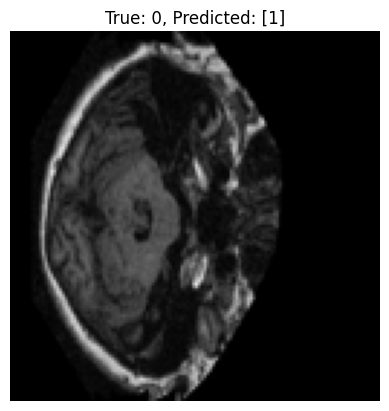

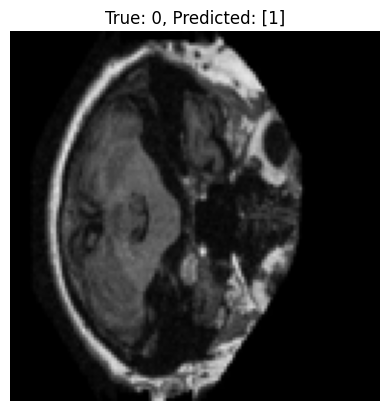

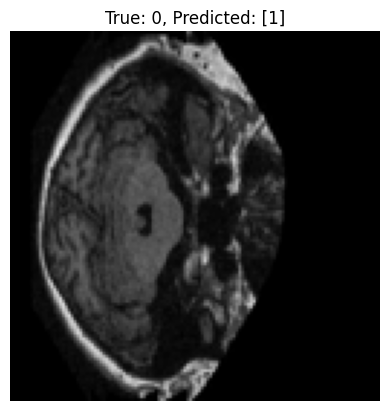

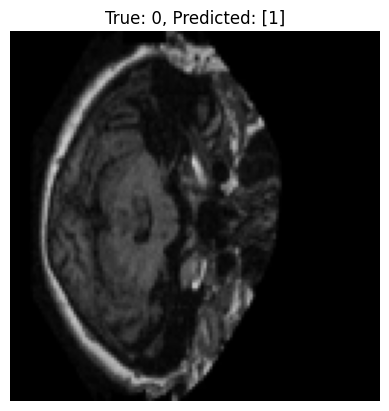

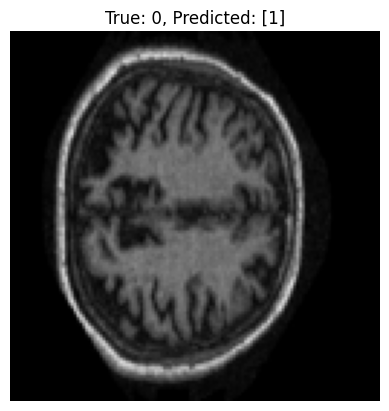

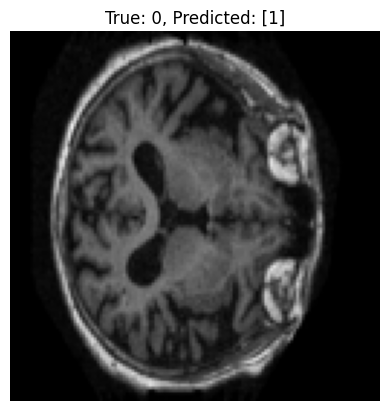

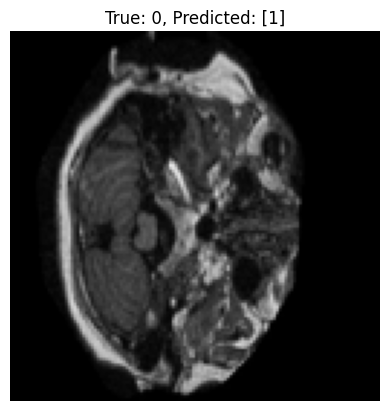

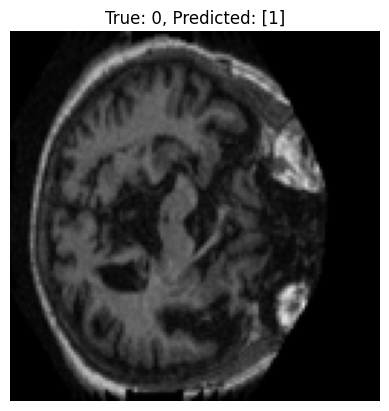

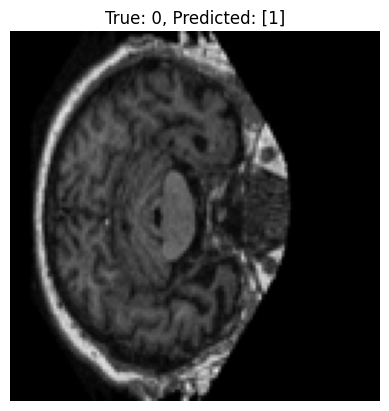

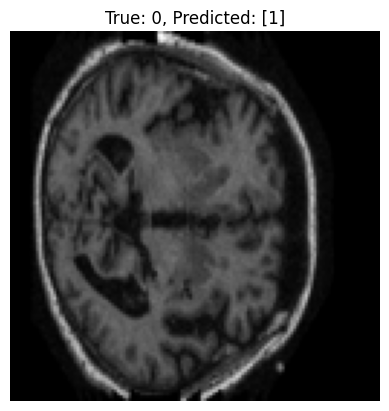

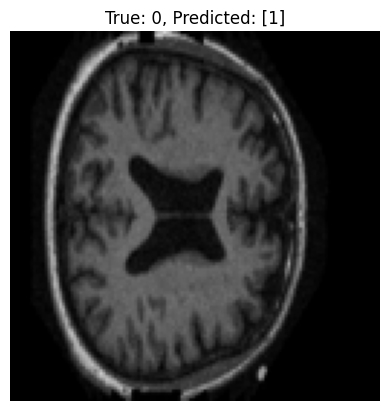

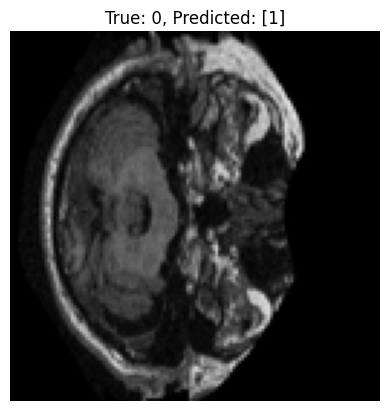

In [ ]:
# 잘못 예측한 인덱스 찾기
misclassified_indexes = np.where(y_pred.reshape(-1) != y_test)[0]  # y_pred와 y_test가 다를 때 인덱스 저장

# 잘못 예측한 mri 출력
for index in misclassified_indexes:
    plt.imshow(X_test[index], cmap='gray')
    plt.title(f"True: {y_test[index]}, Predicted: {y_pred[index]}")
    plt.axis('off')
    plt.show()

# 3-1. Grid Search

In [ ]:
import os
import cv2
import pickle
import random
import pandas as pd
import numpy as np
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

from keras.models import Sequential, load_model
from keras.layers import Conv2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K


from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, confusion_matrix

# 경로 설정
data_dir = "/root/yeoungeun/deeplearning"
pickle_path = os.path.join(data_dir, "dataset.pkl")  # pickle 파일 경로

# Pickle 파일 불러오기
with open(pickle_path, 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

# 불러온 데이터 확인
print("Pickle 파일에서 데이터 불러오기 완료")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

import gc  # 가비지 컬렉션 모듈 추가

# GPU 비활성화 (CPU만 사용)
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# 하이퍼파라미터 설정
param_grid = {
    'batch_size': [32, 16, 8],
    'dropout_rate': [0.25, 0.5],
    'filters': [64, 32],
    'learning_rate': [0.001, 0.0001]
}

# EarlyStopping 설정
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=3,
    verbose=0,
    mode="auto",
    restore_best_weights=True
)

# Specificity 정의 (특이도)
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Scorer 정의
specificity_scorer = make_scorer(specificity)
accuracy_scorer = make_scorer(accuracy_score)
precision_scorer = make_scorer(precision_score)
sensitivity_scorer = make_scorer(recall_score)

# CNN 모델 생성 함수
def create_compile_model(dropout_rate=0.25, filters=32, learning_rate=0.001):
    opt = Adam(learning_rate=learning_rate)
    model = Sequential([
        Conv2D(filters, kernel_size=2, padding='Same', activation='relu', input_shape=(128, 128, 3)),
        BatchNormalization(), MaxPooling2D(pool_size=(2, 2)), Dropout(dropout_rate),
        Conv2D(filters * 2, kernel_size=2, padding='Same', activation='relu'),
        BatchNormalization(), MaxPooling2D(pool_size=(2, 2)), Dropout(dropout_rate),
        Conv2D(filters * 4, kernel_size=2, padding='Same', activation='relu'),
        BatchNormalization(), MaxPooling2D(pool_size=(2, 2)), Dropout(dropout_rate),
        Flatten(), Dense(256, activation='relu'), Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 결과를 저장할 파일 경로
results_file = os.path.join(data_dir, 'grid_search_results.pkl')

# 이전에 완료된 결과가 있다면 로드
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        completed_results = pickle.load(f)
else:
    completed_results = []

# ParameterGrid로 모든 파라미터 조합을 생성하여 각 조합에 대해 학습
for i, params in enumerate(ParameterGrid(param_grid)):
    if any(r['params'] == params for r in completed_results):
        print(f"Skipping already completed params: {params}")
        continue

    print(f"Training with params: {params} (Combination {i+1}/{len(ParameterGrid(param_grid))})")
    batch_size = params['batch_size']
    dropout_rate = params['dropout_rate']
    filters = params['filters']
    learning_rate = params['learning_rate']
    

    # EarlyStopping 재설정
    early_stopping = EarlyStopping(
        monitor="val_loss",
        min_delta=0.00001,
        patience=3,
        verbose=0,
        mode="auto",
        restore_best_weights=True
    )


    # 모델 생성
    model = create_compile_model(dropout_rate, filters, learning_rate)
    
    # 모델 학습
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=15,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1  # 에폭 진행 상황 표시
    )

    # 예측 및 평가
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)
    specificity_score = specificity(y_test, y_pred)

    # 평가 결과 저장
    result = {
        'params': params,
        'accuracy': accuracy,
        'precision': precision,
        'sensitivity': sensitivity,
        'specificity': specificity_score
    }
    completed_results.append(result)

    # 임시 파일에 저장한 후 덮어쓰기
    temp_file = results_file + '.temp'
    with open(temp_file, 'wb') as f:
        pickle.dump(completed_results, f)
    os.replace(temp_file, results_file)  # 임시 파일을 원본 파일로 교체

    # 결과 출력
    print(f"Params: {params}")
    print(f"Accuracy: {accuracy}, Precision: {precision}, Sensitivity: {sensitivity}, Specificity: {specificity_score}")

    # 메모리 정리
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    del model, history, y_pred  # 추가 메모리 해제
    gc.collect()  # 가비지 컬렉션 실행

# 전체 결과 DataFrame으로 변환
results_df = pd.DataFrame(completed_results)
print("\nBest Parameters and Metrics:")
print(results_df.loc[results_df['accuracy'].idxmax()])

# 결과 데이터프레임 저장
results_df.to_csv(os.path.join(data_dir, 'grid_search_results.csv'), index=False)

'''
params,accuracy,precision,sensitivity,specificity
"{'batch_size': 32, 'dropout_rate': 0.25, 'filters': 64, 'learning_rate': 0.001}",0.9862086911267239,0.9816963134828564,0.9908925318761385,0.9815248503773094
"{'batch_size': 32, 'dropout_rate': 0.25, 'filters': 64, 'learning_rate': 0.0001}",0.9867291178766588,0.9923664122137404,0.9810044236273745,0.9924538121259433
"{'batch_size': 32, 'dropout_rate': 0.25, 'filters': 32, 'learning_rate': 0.001}",0.9957064793130367,0.9925025853154085,0.9989591465001301,0.9924538121259433
"{'batch_size': 32, 'dropout_rate': 0.25, 'filters': 32, 'learning_rate': 0.0001}",0.9919333853760083,0.9939900705513457,0.9898516783762685,0.9940150923757481
"{'batch_size': 32, 'dropout_rate': 0.5, 'filters': 64, 'learning_rate': 0.001}",0.8999479573250065,0.9470622454915648,0.8472547488940931,0.9526411657559198
"{'batch_size': 32, 'dropout_rate': 0.5, 'filters': 64, 'learning_rate': 0.0001}",0.5061150143117357,0.9122807017543859,0.013531095498308613,0.9986989331251627
"{'batch_size': 32, 'dropout_rate': 0.5, 'filters': 32, 'learning_rate': 0.001}",0.9571948998178507,0.9268707482993197,0.9927140255009107,0.9216757741347905
"{'batch_size': 32, 'dropout_rate': 0.5, 'filters': 32, 'learning_rate': 0.0001}",0.558808222742649,0.9312977099236641,0.12698412698412698,0.990632318501171
"{'batch_size': 16, 'dropout_rate': 0.25, 'filters': 64, 'learning_rate': 0.001}",0.992583918813427,0.9899068322981367,0.9953161592505855,0.9898516783762685
"{'batch_size': 16, 'dropout_rate': 0.25, 'filters': 64, 'learning_rate': 0.0001}",0.9907624251886546,0.9843348741653827,0.9973978662503252,0.9841269841269841
"{'batch_size': 16, 'dropout_rate': 0.25, 'filters': 32, 'learning_rate': 0.001}",0.9899817850637522,0.9823258196721312,0.9979182930002602,0.9820452771272443
"{'batch_size': 16, 'dropout_rate': 0.25, 'filters': 32, 'learning_rate': 0.0001}",0.9907624251886546,0.9916579770594369,0.9898516783762685,0.9916731720010409
"{'batch_size': 16, 'dropout_rate': 0.5, 'filters': 64, 'learning_rate': 0.001}",0.8809523809523809,0.8551673944687045,0.9172521467603435,0.8446526151444185
"{'batch_size': 16, 'dropout_rate': 0.5, 'filters': 64, 'learning_rate': 0.0001}",0.8456934686442883,0.9314712569015914,0.7462919594067136,0.9450949778818631
"{'batch_size': 16, 'dropout_rate': 0.5, 'filters': 32, 'learning_rate': 0.001}",0.9492583918813428,0.918951710749818,0.9854280510018215,0.9130887327608639
"{'batch_size': 16, 'dropout_rate': 0.5, 'filters': 32, 'learning_rate': 0.0001}",0.5451470205568566,0.9006928406466512,0.1014832162373146,0.9888108248763986
"{'batch_size': 8, 'dropout_rate': 0.25, 'filters': 64, 'learning_rate': 0.001}",0.989591465001301,0.9813251470964441,0.9981785063752276,0.9810044236273745
"{'batch_size': 8, 'dropout_rate': 0.25, 'filters': 64, 'learning_rate': 0.0001}",0.9946656258131668,0.9909607438016529,0.9984387197501952,0.9908925318761385
"{'batch_size': 8, 'dropout_rate': 0.25, 'filters': 32, 'learning_rate': 0.001}",0.987639864689045,0.9872594903796151,0.9880301847514962,0.9872495446265938
"{'batch_size': 8, 'dropout_rate': 0.25, 'filters': 32, 'learning_rate': 0.0001}",0.9946656258131668,0.9909607438016529,0.9984387197501952,0.9908925318761385
"{'batch_size': 8, 'dropout_rate': 0.5, 'filters': 64, 'learning_rate': 0.001}",0.8642987249544627,0.8233256351039261,0.9276606817590424,0.8009367681498829
"{'batch_size': 8, 'dropout_rate': 0.5, 'filters': 64, 'learning_rate': 0.0001}",0.9078844652615145,0.880368842513953,0.9440541243819932,0.8717148061410357
"{'batch_size': 8, 'dropout_rate': 0.5, 'filters': 32, 'learning_rate': 0.001}",0.9547228727556596,0.9416224412433661,0.9695550351288056,0.9398907103825137
"{'batch_size': 8, 'dropout_rate': 0.5, 'filters': 32, 'learning_rate': 0.0001}",0.8957845433255269,0.918547055586131,0.868592245641426,0.9229768410096278


Best Parameters and Metrics:
params         {'batch_size': 32, 'dropout_rate': 0.25, 'filt...
accuracy                                                0.995706
precision                                               0.992503
sensitivity                                             0.998959
specificity                                             0.992454
Name: 2, dtype: object
'''

# 모델 평가지표 출력

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# 학습 및 검증 정확도 그래프
val_accuracy = history.history['val_accuracy']
train_accuracy = history.history['accuracy']
epochs = range(1, len(val_accuracy) + 1)

plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, train_accuracy, linestyle='--', label='Train Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# 예측 및 혼동 행렬 생성
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)  # 이진 분류이므로 argmax 대신 round 사용

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 평가지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)  # sensitivity
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

# 평가지표 출력
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Sensitivity (Recall): {recall:.4f}')
print(f'Specificity: {specificity:.4f}')

# 평가지표 시각화
metrics = ['Accuracy', 'Precision', 'Sensitivity (Recall)', 'Specificity']
values = [accuracy, precision, recall, specificity]

plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.ylim(0, 1)
plt.title('Evaluation Metrics')
plt.ylabel('Score')
plt.grid()
plt.show()


# External validation by OASIS

Oasis dataset

RAW 데이터 개수: 436
RAW ID 목록: ['OAS1_0001_MR1', 'OAS1_0002_MR1', 'OAS1_0003_MR1', 'OAS1_0004_MR1', 'OAS1_0005_MR1', 'OAS1_0006_MR1', 'OAS1_0007_MR1', 'OAS1_0009_MR1', 'OAS1_0010_MR1', 'OAS1_0011_MR1', 'OAS1_0012_MR1', 'OAS1_0013_MR1', 'OAS1_0014_MR1', 'OAS1_0015_MR1', 'OAS1_0016_MR1', 'OAS1_0017_MR1', 'OAS1_0018_MR1', 'OAS1_0019_MR1', 'OAS1_0020_MR1', 'OAS1_0021_MR1', 'OAS1_0022_MR1', 'OAS1_0023_MR1', 'OAS1_0025_MR1', 'OAS1_0026_MR1', 'OAS1_0027_MR1', 'OAS1_0028_MR1', 'OAS1_0029_MR1', 'OAS1_0030_MR1', 'OAS1_0031_MR1', 'OAS1_0032_MR1', 'OAS1_0033_MR1', 'OAS1_0034_MR1', 'OAS1_0035_MR1', 'OAS1_0037_MR1', 'OAS1_0038_MR1', 'OAS1_0039_MR1', 'OAS1_0040_MR1', 'OAS1_0041_MR1', 'OAS1_0042_MR1', 'OAS1_0043_MR1', 'OAS1_0044_MR1', 'OAS1_0045_MR1', 'OAS1_0046_MR1', 'OAS1_0047_MR1', 'OAS1_0049_MR1', 'OAS1_0050_MR1', 'OAS1_0051_MR1', 'OAS1_0052_MR1', 'OAS1_0053_MR1', 'OAS1_0054_MR1', 'OAS1_0055_MR1', 'OAS1_0056_MR1', 'OAS1_0057_MR1', 'OAS1_0058_MR1', 'OAS1_0059_MR1', 'OAS1_0060_MR1', 'OAS1_0061_MR1', 'OA

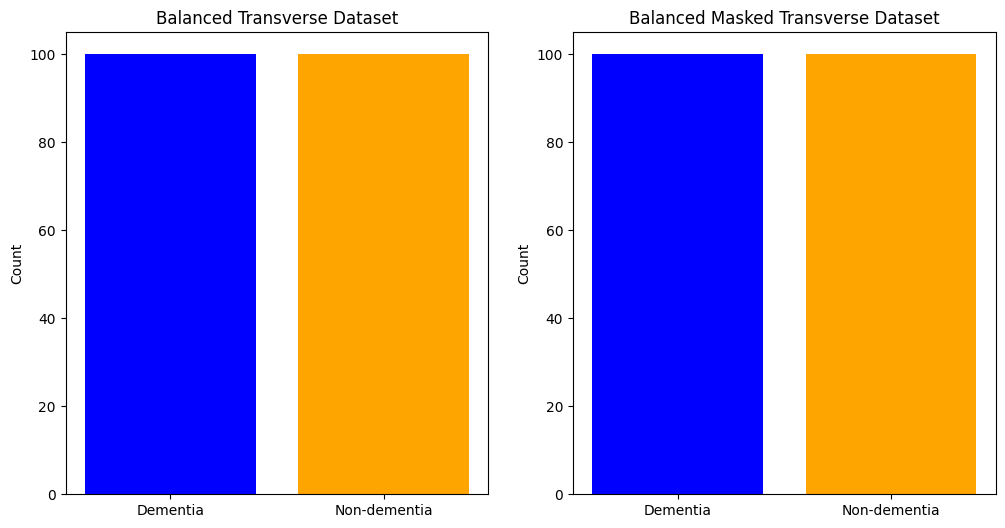

Shape of X_transverse: (200, 128, 128)
Shape of y_transverse: 200


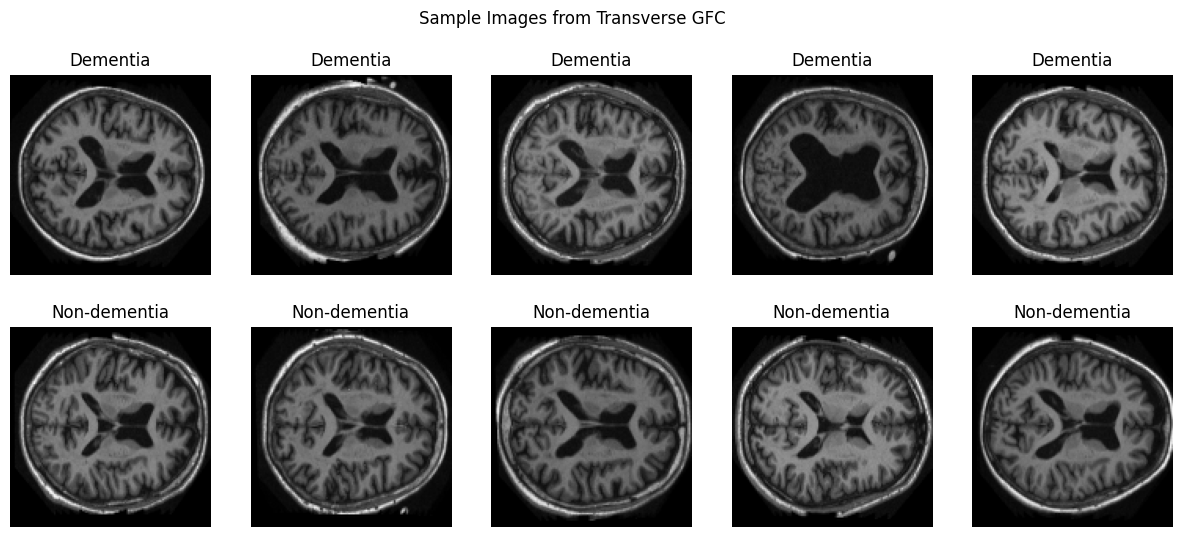

Shape of X_masked: (200, 128, 128)
Shape of y_masked: 200


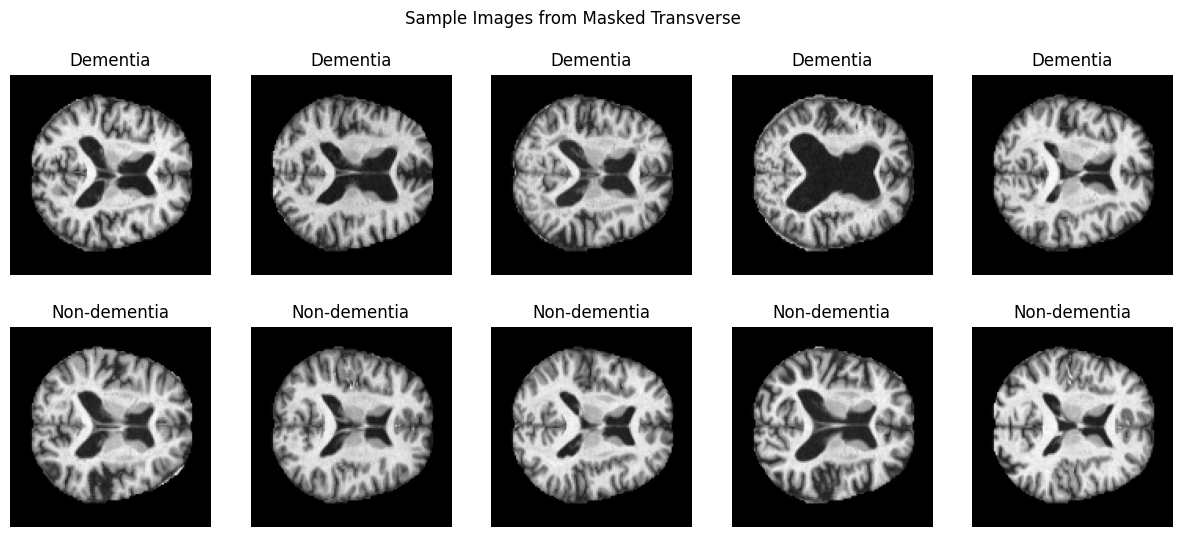

In [35]:
import os
import imageio
import numpy as np
import pandas as pd
from scipy.ndimage import zoom
import pickle
import matplotlib.pyplot as plt

####################################
## 0. 데이터 로드
####################################
# 경로 설정
excel_file_path = "C:/Users/USER/Desktop/브레이니화_딥러닝/dataset/oasis_cross-sectional-5708aa0a98d82080.xlsx"
data_dir = "C:/Users/USER/Desktop/브레이니화_딥러닝/dataset"

# 엑셀 파일에서 인구통계학적 정보를 데이터프레임으로 로드 - 모든 정보를 가져옴
df = pd.read_excel(excel_file_path)
df = df[['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Delay']]

####################################
## 1. 결측값 제거
####################################
print(f"RAW 데이터 개수: {len(df)}")
missing_initial = df[df.isna().any(axis=1)]
print(f"RAW ID 목록: {missing_initial['ID'].tolist()}")

# CDR 값이 없는 경우 제거
removed_ids = df[df['CDR'].isna()]['ID'].tolist() 
df_before = len(df)
df = df.dropna(subset=['CDR'])
df_after = len(df)

print(f"CDR 기준 제거된 개수: {df_before - df_after}")
print(f"CDR 기준 제거된 ID 목록: {removed_ids}")

# MRI와 레이블 정보를 위한 딕셔너리 생성
transverse_images_gfc = {}
transverse_images_masked = {}
labels = []

# 이미지 크기 조정, 90도 회전 및 밝기 조정 함수
def resize_image(image, new_shape=(128, 128)):
    current_shape = image.shape[:2]
    zoom_factors = [n / c for n, c in zip(new_shape, current_shape)]
    resized_image = zoom(image, zoom_factors)
    rotated_image = np.rot90(resized_image, k=-1)  # 오른쪽으로 90도 회전
    darkened_image = rotated_image  # 밝기 조정 x
    return darkened_image

# 데이터 로드 및 저장
for disc_num in range(1, 13):
    disc_path = os.path.join(data_dir, f"oasis_cross-sectional_disc{disc_num}")
    if not os.path.exists(disc_path):
        print(f"Disc path does not exist: {disc_path}")
        continue
    
    for sub_folder in os.listdir(disc_path):
        sub_folder_path = os.path.join(disc_path, sub_folder)
        
        if not os.path.isdir(sub_folder_path):
            continue
        
        for subject_dir in os.listdir(sub_folder_path):
            subject_path = os.path.join(sub_folder_path, subject_dir)
            if not os.path.isdir(subject_path):
                continue

            session_path = subject_path
            t88_111_path = os.path.join(session_path, "PROCESSED", "MPRAGE", "T88_111")
            
            if os.path.exists(t88_111_path):
                for file in os.listdir(t88_111_path):
                    file_path = os.path.join(t88_111_path, file)

                    if file.endswith("_tra_90.gif"):
                        if "masked_gfc" in file:
                            img = imageio.v2.imread(file_path)
                            img_resized = resize_image(img)
                            transverse_images_masked[subject_dir] = img_resized
                        else:
                            img = imageio.v2.imread(file_path)
                            img_resized = resize_image(img)
                            transverse_images_gfc[subject_dir] = img_resized

                    subject_id = subject_dir
                    subject_info = df[df['ID'] == subject_id]

                    if not subject_info.empty:
                        cdr_value = subject_info['CDR'].values[0]
                        labels.append((subject_id, cdr_value))

####################################
## 2. 레이블 개수 확인 및 출력 (밸런싱 전)
####################################
labels_dict = dict(labels)

# transverse의 치매/비치매 개수
dementia_count_gfc = sum(1 for s in transverse_images_gfc if s in labels_dict and labels_dict[s] >= 0.5)
non_dementia_count_gfc = sum(1 for s in transverse_images_gfc if s in labels_dict and labels_dict[s] == 0)
print(f"transverse 치매: {dementia_count_gfc}, 비치매: {non_dementia_count_gfc}")

# masked transverse의 치매/비치매 개수
dementia_count_masked = sum(1 for s in transverse_images_masked if s in labels_dict and labels_dict[s] >= 0.5)
non_dementia_count_masked = sum(1 for s in transverse_images_masked if s in labels_dict and labels_dict[s] == 0)
print(f"masked transverse 치매: {dementia_count_masked}, 비치매: {non_dementia_count_masked}")

####################################
## 3. 정규화(Normalization)
####################################

def normalize_image(image):
    return image / 255.0 if image.max() > 0 else image

transverse_images_gfc_normalized = {subject: normalize_image(img) for subject, img in transverse_images_gfc.items()}
transverse_images_masked_normalized = {subject: normalize_image(img) for subject, img in transverse_images_masked.items()}

####################################
## 4. 레이블 개수 맞추기 (밸런싱)
####################################

# transverse 데이터셋에서 밸런싱
dementia_subjects_gfc = [s for s in transverse_images_gfc_normalized if s in labels_dict and labels_dict[s] >= 0.5]
non_dementia_subjects_gfc = [s for s in transverse_images_gfc_normalized if s in labels_dict and labels_dict[s] == 0]
np.random.seed(42)
non_dementia_balanced_gfc = np.random.choice(non_dementia_subjects_gfc, size=len(dementia_subjects_gfc), replace=False).tolist()
balanced_subjects_gfc = dementia_subjects_gfc + non_dementia_balanced_gfc
balanced_labels_gfc = [1] * len(dementia_subjects_gfc) + [0] * len(non_dementia_balanced_gfc)
print(f"Balanced transverse 치매: {len(dementia_subjects_gfc)}, 비치매: {len(non_dementia_balanced_gfc)}")

# masked transverse 데이터셋에서 밸런싱
dementia_subjects_masked = [s for s in transverse_images_masked_normalized if s in labels_dict and labels_dict[s] >= 0.5]
non_dementia_subjects_masked = [s for s in transverse_images_masked_normalized if s in labels_dict and labels_dict[s] == 0]
non_dementia_balanced_masked = np.random.choice(non_dementia_subjects_masked, size=len(dementia_subjects_masked), replace=False).tolist()
balanced_subjects_masked = dementia_subjects_masked + non_dementia_balanced_masked
balanced_labels_masked = [1] * len(dementia_subjects_masked) + [0] * len(non_dementia_balanced_masked)
print(f"Balanced masked transverse 치매: {len(dementia_subjects_masked)}, 비치매: {len(non_dementia_balanced_masked)}")

####################################
## 5. 데이터셋 저장
####################################

def convert_images_to_array(image_dict, subject_list):
    return np.array([image_dict[subject] for subject in subject_list if subject in image_dict])

X_transverse_gfc = convert_images_to_array(transverse_images_gfc_normalized, balanced_subjects_gfc)
X_transverse_masked = convert_images_to_array(transverse_images_masked_normalized, balanced_subjects_masked)

# 데이터셋 저장
with open("transverse_gfc_dataset.pkl", "wb") as f:
    pickle.dump((X_transverse_gfc, balanced_labels_gfc), f)

with open("transverse_masked_dataset.pkl", "wb") as f:
    pickle.dump((X_transverse_masked, balanced_labels_masked), f)

print("Data saved as transverse_gfc_dataset.pkl and transverse_masked_dataset.pkl.")

####################################
## 6. 그래프 시각화
####################################

# 밸런싱 후 데이터 개수 시각화
categories = ['Dementia', 'Non-dementia']
transverse_counts = [len(dementia_subjects_gfc), len(non_dementia_balanced_gfc)]
masked_counts = [len(dementia_subjects_masked), len(non_dementia_balanced_masked)]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(categories, transverse_counts, color=['blue', 'orange'])
ax[0].set_title('Balanced Transverse Dataset')
ax[0].set_ylabel('Count')

ax[1].bar(categories, masked_counts, color=['blue', 'orange'])
ax[1].set_title('Balanced Masked Transverse Dataset')
ax[1].set_ylabel('Count')

plt.show()

# 샘플 이미지 출력 함수
def display_sample_images(X, y, dataset_name):
    # Dementia와 Non-dementia 각각에서 5개씩 샘플 출력
    dementia_indices = np.where(np.array(y) == 1)[0][:5]
    non_dementia_indices = np.where(np.array(y) == 0)[0][:5]

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f"Sample Images from {dataset_name}")

    for i, idx in enumerate(dementia_indices):
        axes[0, i].imshow(X[idx], cmap='gray')
        axes[0, i].set_title("Dementia")
        axes[0, i].axis("off")

    for i, idx in enumerate(non_dementia_indices):
        axes[1, i].imshow(X[idx], cmap='gray')
        axes[1, i].set_title("Non-dementia")
        axes[1, i].axis("off")

    plt.show()
    
    
# 데이터셋 로드 후 샘플 이미지 출력
with open("transverse_gfc_dataset.pkl", "rb") as f:
    X_transverse, y_transverse = pickle.load(f)
    print("Shape of X_transverse:", X_transverse.shape)  
    print("Shape of y_transverse:", len(y_transverse))
    display_sample_images(X_transverse, y_transverse, "Transverse GFC")

with open("transverse_masked_dataset.pkl", "rb") as f:
    X_masked, y_masked = pickle.load(f)
    print("Shape of X_masked:", X_masked.shape)
    print("Shape of y_masked:", len(y_masked))
    display_sample_images(X_masked, y_masked, "Masked Transverse")


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
7/7 [==============================] - 1s 79ms/step


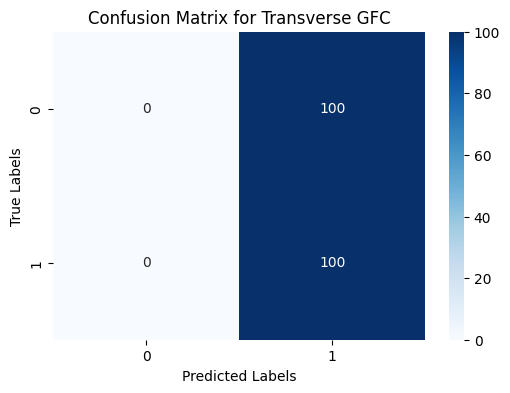

Results for Transverse GFC:
Accuracy: 0.5000
Precision: 0.5000
Sensitivity (Recall): 1.0000
Specificity: 0.0000


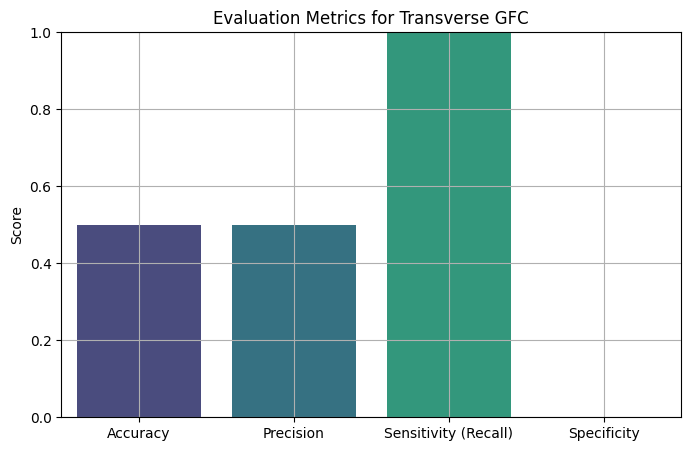

7/7 [==============================] - 0s 34ms/step


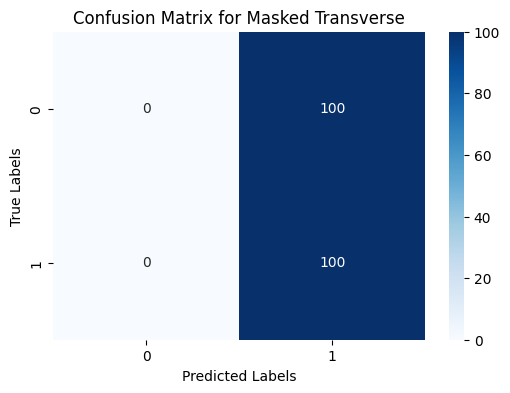

Results for Masked Transverse:
Accuracy: 0.5000
Precision: 0.5000
Sensitivity (Recall): 1.0000
Specificity: 0.0000


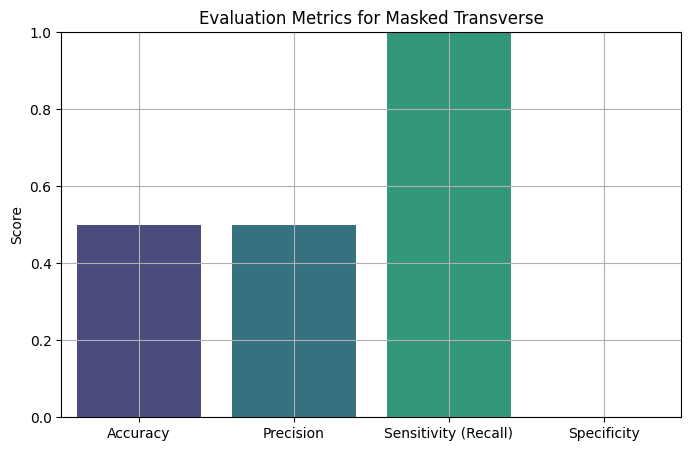

In [34]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.models import load_model

# 저장된 모델 경로
model_path = "C:/Users/USER/Desktop/Braineewha_DeepLearning_11/model/best_binary_model.keras"
model = load_model(model_path)

# 피클 파일 로드
with open("transverse_gfc_dataset.pkl", "rb") as f:
    X_transverse, y_transverse = pickle.load(f)

with open("transverse_masked_dataset.pkl", "rb") as f:
    X_masked, y_masked = pickle.load(f)

# 입력 데이터 형태 조정 - 수정된 부분
if X_transverse.shape[-1] != 3:  # 단일 채널이면 3채널로 변환
    X_transverse = np.stack((X_transverse,) * 3, axis=-1)

if X_masked.shape[-1] != 3:  # 단일 채널이면 3채널로 변환
    X_masked = np.stack((X_masked,) * 3, axis=-1)

# 검증 함수 정의
def evaluate_model(model, X_test, y_test, dataset_name="Dataset"):
    # 예측 수행
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred).astype(int)  # 이진 분류용 예측 결과

    # 혼동 행렬 생성 및 시각화
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {dataset_name}')
    plt.show()

    # 평가지표 계산
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    # 평가지표 출력
    print(f'Results for {dataset_name}:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Sensitivity (Recall): {recall:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 평가지표 시각화
    metrics = ['Accuracy', 'Precision', 'Sensitivity (Recall)', 'Specificity']
    values = [accuracy, precision, recall, specificity]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=metrics, y=values, palette="viridis")
    plt.ylim(0, 1)
    plt.title(f'Evaluation Metrics for {dataset_name}')
    plt.ylabel('Score')
    plt.grid()
    plt.show()

# 모델 평가 수행
evaluate_model(model, X_transverse, y_transverse, dataset_name="Transverse GFC")
evaluate_model(model, X_masked, y_masked, dataset_name="Masked Transverse")

